In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import scanpy as sc
import anndata
import torch
import numpy as np 
import pandas as pd
import torch.nn.functional as F
from torch import nn
from torch import optim
from sklearn.model_selection import KFold, StratifiedKFold
from torch.utils.data import DataLoader,TensorDataset,SubsetRandomSampler, WeightedRandomSampler

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')

In [4]:
moudata = np.load('5 x_mou_0831_anno.npz', allow_pickle=True)
x_mou = torch.from_numpy(moudata['x'].astype(np.float32))
y_mou = torch.from_numpy(moudata['y'].astype(np.int32))
y_mou = y_mou.long() - 1
dataset = TensorDataset(x_mou, y_mou)

inputSize = x_mou.shape[1]
outputSize = 14
hiddenSize = 16

In [5]:
x_mou.shape

torch.Size([5512, 4313])

(array([ 310.,  250.,  301.,  602.,  265.,  263.,  122.,   36., 2868.,
         221.,   50.,   63.,   52.,  109.]),
 array([ 0.        ,  0.92857143,  1.85714286,  2.78571429,  3.71428571,
         4.64285714,  5.57142857,  6.5       ,  7.42857143,  8.35714286,
         9.28571429, 10.21428571, 11.14285714, 12.07142857, 13.        ]),
 <BarContainer object of 14 artists>)

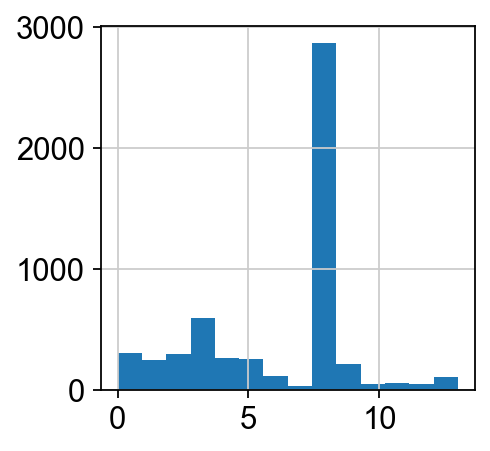

In [3]:
plt.hist(y_mou.numpy(), bins=14)

In [4]:
class OutputHook(list):
    def __call__(self, module, input, output):
        self.append(output)
        
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.relu = nn.ReLU()
        self.layers = nn.Sequential(
            nn.Linear(inputSize, hiddenSize),
            nn.Dropout(0.5),
            nn.Linear(hiddenSize, outputSize),
            self.relu
        )
            
    def forward(self, x):
        out = self.layers(x)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

In [5]:
device = "cuda:0"
torch.manual_seed(42)
num_epochs = 30
batch_size = 64
l1_lambda = 1e-3
k = 5
splits = StratifiedKFold(n_splits = k, shuffle=True, random_state=42)
loss_fn = nn.CrossEntropyLoss()
foldperf={}

In [6]:
def train(model, device, train_idx, loss_fn, optimizer):
    train_loss, train_correct=0.0,0
    model.train()

    x_train = x_mou[train_idx]
    y_train = y_mou[train_idx]

    for i in range(42):
        sample_idx=[]
        for t in np.unique(y_train):
            t_idx = np.where(y_train==t)[0]
            sample_idx.append(np.random.choice(t_idx, size=5))
        sample_idx = np.vstack(sample_idx)
        sample_idx = sample_idx.reshape(sample_idx.size)
        x_sample = x_train[sample_idx]
        y_sample = y_train[sample_idx]

        inputs,labels = x_sample.to(device), y_sample.to(device)
        optimizer.zero_grad()
        output = model(inputs.float())

        l1_penalty = 0.
        for output in output_hook:
            l1_penalty += torch.norm(output, 1)
        l1_penalty *= l1_lambda

        loss = loss_fn(output,labels) + l1_penalty
        loss.backward()
        optimizer.step()
        output_hook.clear()
        
        train_loss += loss.item() * inputs.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct

def val(model, device, val_idx, loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()

    x_test = x_mou[val_idx]
    y_test = y_mou[val_idx]

    inputs,labels = x_test.to(device),y_test.to(device)
    output = model(inputs)
    loss = loss_fn(output,labels)
    valid_loss += loss.item()*inputs.size(0)
    scores, predictions = torch.max(output.data,1)
    val_correct += (predictions == labels).sum().item()

    return valid_loss,val_correct

In [8]:
#for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
for fold, (train_idx,val_idx) in enumerate(splits.split(x_mou,y_mou)):
    torch.cuda.empty_cache()
    print('Fold {}'.format(fold + 1))

    #train_sampler = SubsetRandomSampler(train_idx)
    #test_sampler = SubsetRandomSampler(val_idx)
    x_train = x_mou[train_idx]
    y_train = y_mou[train_idx]
    train_set = TensorDataset(x_train, y_train)

    x_test = x_mou[val_idx]
    y_test = y_mou[val_idx]
    test_set = TensorDataset(x_train, y_train)

    #train_sampler = StratifiedBatchSampler(y_train, batch_size=batch_size)
    #test_sampler = StratifiedBatchSampler(y_test, batch_size=batch_size)
    
    #train_loader = DataLoader(dataset, batch_sampler=train_sampler)
    #test_loader = DataLoader(dataset, batch_sampler=test_sampler)
    
    model = ANN()
    model.to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=0.001)

    output_hook = OutputHook()
    model.relu.register_forward_hook(output_hook)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        
        train_loss, train_correct = train(model, device, train_idx, loss_fn, optimizer)
        test_loss, test_correct = val(model, device, val_idx, loss_fn)

        train_loss = train_loss / (train_loss+train_correct)
        train_acc = train_correct / (train_loss+train_correct) * 100
        test_loss = test_loss / (test_loss+test_correct)
        test_acc = test_correct / (test_loss+test_correct) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(
            epoch + 1, num_epochs, train_loss, test_loss, train_acc, test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  

Fold 1
Epoch:1/30 AVG Training Loss:0.759 AVG Test Loss:0.716 AVG Training Acc 99.96 % AVG Test Acc 99.93 %
Epoch:2/30 AVG Training Loss:0.677 AVG Test Loss:0.712 AVG Training Acc 99.97 % AVG Test Acc 99.93 %
Epoch:3/30 AVG Training Loss:0.628 AVG Test Loss:0.711 AVG Training Acc 99.98 % AVG Test Acc 99.93 %
Epoch:4/30 AVG Training Loss:0.604 AVG Test Loss:0.706 AVG Training Acc 99.98 % AVG Test Acc 99.93 %
Epoch:5/30 AVG Training Loss:0.576 AVG Test Loss:0.710 AVG Training Acc 99.98 % AVG Test Acc 99.93 %
Epoch:6/30 AVG Training Loss:0.563 AVG Test Loss:0.707 AVG Training Acc 99.98 % AVG Test Acc 99.93 %
Epoch:7/30 AVG Training Loss:0.558 AVG Test Loss:0.709 AVG Training Acc 99.98 % AVG Test Acc 99.93 %
Epoch:8/30 AVG Training Loss:0.545 AVG Test Loss:0.712 AVG Training Acc 99.98 % AVG Test Acc 99.93 %
Epoch:9/30 AVG Training Loss:0.539 AVG Test Loss:0.712 AVG Training Acc 99.98 % AVG Test Acc 99.93 %
Epoch:10/30 AVG Training Loss:0.534 AVG Test Loss:0.713 AVG Training Acc 99.98 % AVG

In [12]:
foldperf['fold1']['test_acc']

[99.92602099097296,
 99.92859075821295,
 99.92892075749853,
 99.93048402930343,
 99.92964051910901,
 99.93049883638386,
 99.92981091615296,
 99.92935091213658,
 99.9292569032118,
 99.92936096966109,
 99.9289067570098,
 99.92817078319021,
 99.92950959956288,
 99.92463275450085,
 99.92706145052622,
 99.92463005467128,
 99.92290842820887,
 99.92350001503432,
 99.92228124329009,
 99.9202152351856,
 99.91918945958386,
 99.91748699948278,
 99.92238496814443,
 99.91836298532817,
 99.91815830127607,
 99.91617577947103,
 99.9123772701464,
 99.91435063958183,
 99.91390820263057,
 99.91080943038907]

In [13]:
torch.save(model,'ANN_0912_equalSample.pt')

In [10]:
#ann = torch.load('ANN_0831.pt')
model = torch.load('ANN_0912_equalSample.pt')
model.to(device)

ANN(
  (relu): ReLU()
  (layers): Sequential(
    (0): Linear(in_features=4313, out_features=16, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=16, out_features=14, bias=True)
    (3): ReLU()
  )
)

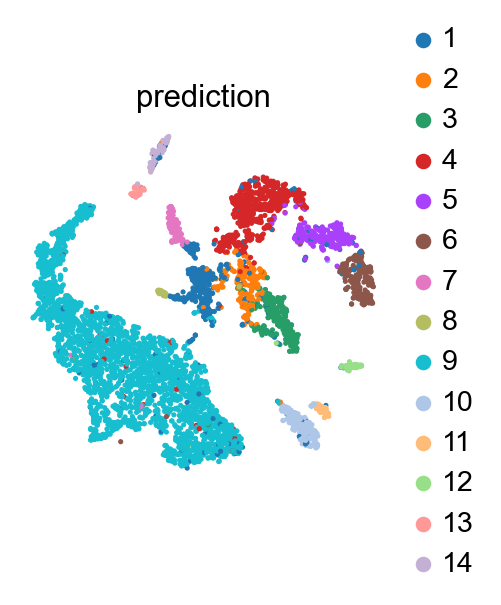

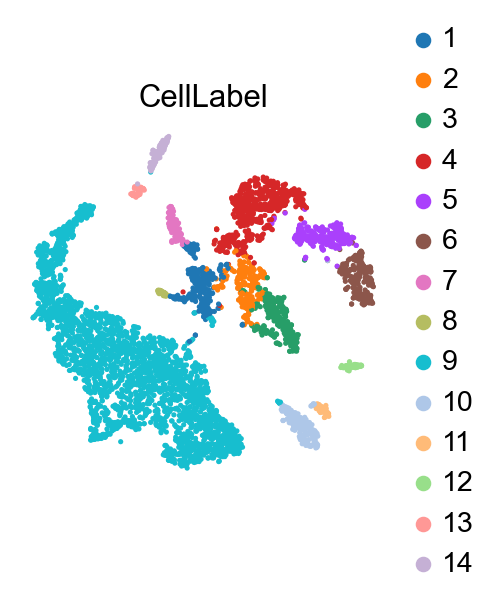

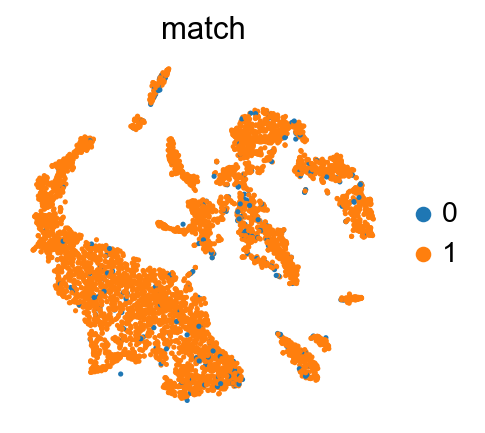

0.9550072568940493

In [14]:
adata = sc.read_h5ad('3 clustered_mou_0831_anno.h5ad')
v,p = torch.max(model(x_mou.to(device)),1)
adata.obs['prediction'] = p.cpu().detach().numpy() + 1
adata.obs = adata.obs.astype({'prediction': 'category'})
adata.obs['match'] = ((adata.obs['prediction'].astype('int64') == adata.obs['CellLabel'].astype('int64'))*1).astype('category')

sc.pl.tsne(adata,color='prediction')
sc.pl.tsne(adata,color='CellLabel')
sc.pl.tsne(adata,color='match')

np.sum(adata.obs['match'].astype('int64'))/adata.obs['match'].shape[0]